In [1]:
import cupy as np 
import cudf as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import cuml
from cuml import LinearRegression
from sklearn import linear_model
from sklearn import preprocessing

In [2]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

**Exploratory Data Analysis**

In this initial investigations on data will be performed to to develop an understanding of the data, discover patterns and spot anomalies.

In [3]:
# load the datasets into dataframe
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv',error_bad_lines=False)
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv',error_bad_lines=False)

In [4]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal,250000


In [5]:
# check the number of records and columns in both of datasets
print('No. of records in train dataset: ', len(train.index))
print('No. of columns in train dataset: ', len(train.columns))
print('No. of records in test dataset: ', len(test.index))
print('No. of columns in test dataset: ', len(test.columns))

No. of records in train dataset:  1460
No. of columns in train dataset:  81
No. of records in test dataset:  1459
No. of columns in test dataset:  80


In [6]:
# check the missing values
print ('Total missing values in train set', sum(train.to_pandas().isna().sum()))
print ('Total missing values in test set', sum(test.to_pandas().isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The above line code shows that the average sale price of a house is close to 180,000 with most of the values falling within the 130,000 to 215,000 range. Next step is to show the relationship between the columns to examine the correlations between the features and the target.

In [8]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.to_pandas().corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

The most correlated features to sale price were the overall quality score (79%), above-ground living area (71%), garage area (64%), and number-of-car garage (62%). Next step is to plot each variable individually against SalePrice in a scatter plot to check outliers as outliers can affect the regression model by pulling the estimated regression line further away from the true population regression line.

Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

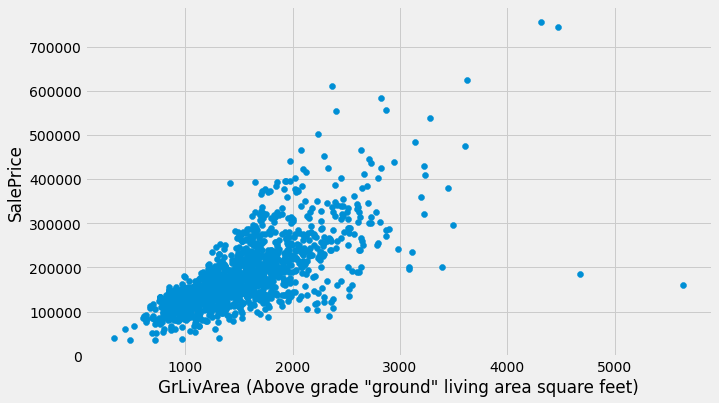

In [9]:
plt.scatter(x = train['GrLivArea'].to_array(), y = train['SalePrice'].to_array())
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

At first glance, there are increases in living area correspond to increases in price, with few outliers.

Text(0.5, 0, 'GarageArea')

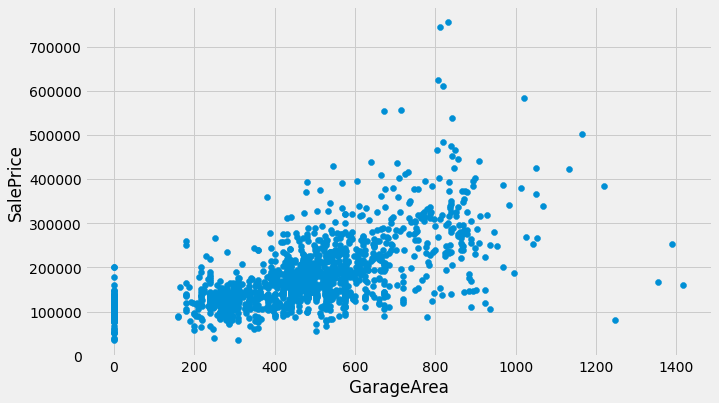

In [10]:
plt.scatter(x = train['GarageArea'].to_array(), y = train['SalePrice'].to_array())
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

So there are many homes with 0 for GarageArea and there are a few outliers as well!

**Data Preprocessing**

In this section the data is prepared (transformed, encoded, etc) to make it suitable for a building and training machine learning model. I chose to manually remove certain extreme outliers in the dataset to produce a better fit.

In [11]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [12]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [13]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
index=train_percentage[train_percentage > 0.80].index
#print(index)
train = train.drop(index.to_array(), axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [14]:
# do the same with test data
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index.to_array(), axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [15]:
# encode categorical variables
le = preprocessing.LabelEncoder()
train=train.to_pandas()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [16]:
# do the same for testset
test=test.to_pandas()
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

There are many ways to handle NaN values, whether to fill with the mean or median, however strings cannot be averaged or median-ed. One way to fill missing values is to impute these missing values according to their probability of occuring in the dataset to avoid single-valued imputation that impacts the quality of inference and prediction.

In [17]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    random_choice=np.random.choice(a, train[column].isnull().sum(), p = b / b.sum());
    random_choice=np.asnumpy(random_choice)
    cna=train[column].isna().to_numpy()
    train.loc[cna, column] = random_choice

In [18]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
sti=skewed_train.index
tsti=train[skewed_train.index]
train[sti] = np.log1p(np.asarray(tsti.to_numpy()))

In [19]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
var_ti=test[skewed_test.index]
ans=np.log1p(np.asarray(var_ti.to_numpy()))
#print(type(ans))
test[skewed_test.index] = ans

**Modelling**

I will perform a simple linear regression on the dataset to predict house prices. In order to train out the regression model, we need to first split up the data into an X list that contains the features to train on, and a y list with the target variable, in this case, the Price column.

In [20]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice'].to_frame()
y=y.to_numpy()
y=y.reshape(-1,1)

In [21]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X.to_numpy())

In [22]:
X_scaled

array([[ 0.4247723 , -0.04927459,  0.26569587, ...,  0.13862295,
         0.31008211,  0.21179671],
       [-1.12571581, -0.04927459,  0.41331235, ..., -0.61345827,
         0.31008211,  0.21179671],
       [ 0.4247723 , -0.04927459,  0.29773685, ...,  0.13862295,
         0.31008211,  0.21179671],
       ...,
       [ 0.64550011, -0.04927459,  0.27653522, ...,  1.64278538,
         0.31008211,  0.21179671],
       [-1.12571581, -0.04927459,  0.29773685, ...,  1.64278538,
         0.31008211,  0.21179671],
       [-1.12571581, -0.04927459,  0.36738578, ...,  0.13862295,
         0.31008211,  0.21179671]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1163, 75)
(291, 75)
(1163, 1)
(291, 1)


In [25]:
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")

In [26]:
reg = lr.fit(X_train,y_train)

In [27]:
# make predictions based on model
preds = lr.predict(X_test)

In [28]:
mse_e=mean_squared_error(y_test,preds)
rs_e=r2_score(y_test,preds)
mae_e=mean_absolute_error(y_test,preds)

Text(0.5, 1.0, 'Linear Regression Model eig')

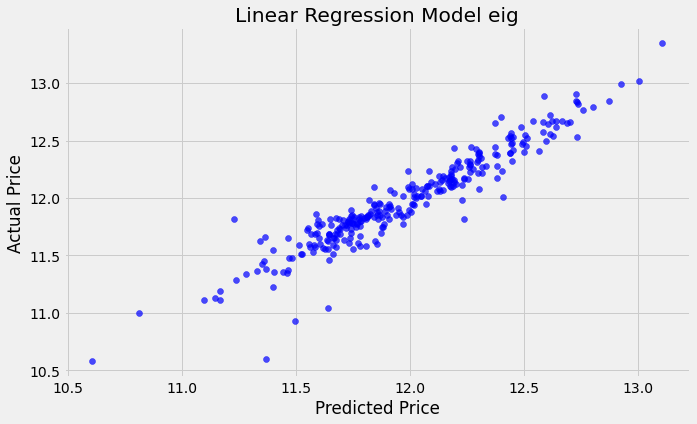

In [29]:
# alpha helps to show overlapping data
plt.scatter(preds, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model eig')

In [30]:
lrs=LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "svd")

In [31]:
regs = lrs.fit(X_train,y_train)

In [32]:
predss = lrs.predict(X_test)

In [33]:
mse_s=mean_squared_error(y_test,predss)
rs_s=r2_score(y_test,predss)
mae_s=mean_absolute_error(y_test,predss)

Text(0.5, 1.0, 'Linear Regression Model svd')

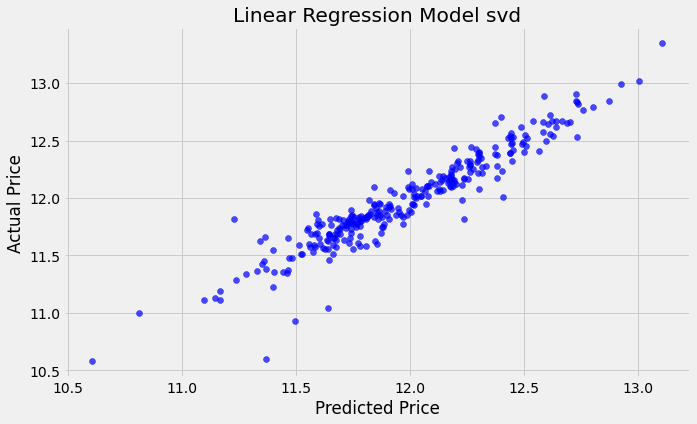

In [34]:
# alpha helps to show overlapping data
plt.scatter(preds, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model svd')

In [35]:
lrsq=LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "qr")

In [36]:
regsq = lrsq.fit(X_train,y_train)

In [37]:
predsq = lrsq.predict(X_test)

In [38]:
mse_q=mean_squared_error(y_test,predsq)
rs_q=r2_score(y_test,predsq)
mae_q=mean_absolute_error(y_test,predsq)

Text(0.5, 1.0, 'Linear Regression Model qr')

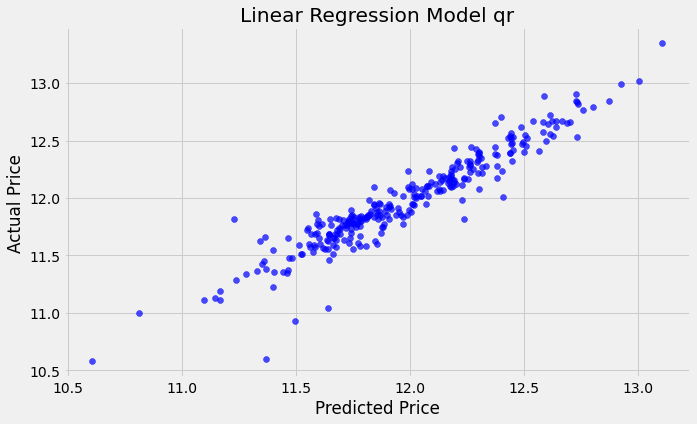

In [39]:
# alpha helps to show overlapping data
plt.scatter(preds, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model qr')

In [40]:
lrssq=LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "svd-qr")

In [41]:
regssq = lrssq.fit(X_train,y_train)

In [42]:
predssq = lrssq.predict(X_test)

In [43]:
mse_sq=mean_squared_error(y_test,predssq)
rs_sq=r2_score(y_test,predssq)
mae_sq=mean_absolute_error(y_test,predssq)

Text(0.5, 1.0, 'Linear Regression Model svd-qr')

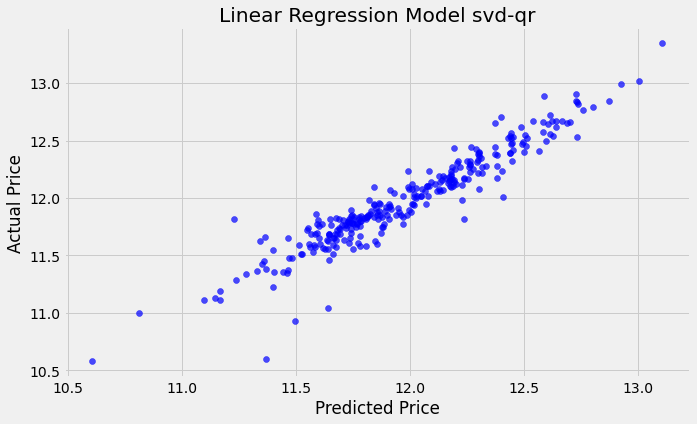

In [44]:
# alpha helps to show overlapping data
plt.scatter(preds, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model svd-qr')

In [45]:
lrssj=LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "svd-jacobi")

In [46]:
regssj = lrssj.fit(X_train,y_train)

In [47]:
predssj = lrssj.predict(X_test)

In [48]:
mse_sj=mean_squared_error(y_test,predssj)
rs_sj=r2_score(y_test,predssj)
mae_sj=mean_absolute_error(y_test,predssj)

Text(0.5, 1.0, 'Linear Regression Model svd-jacobi')

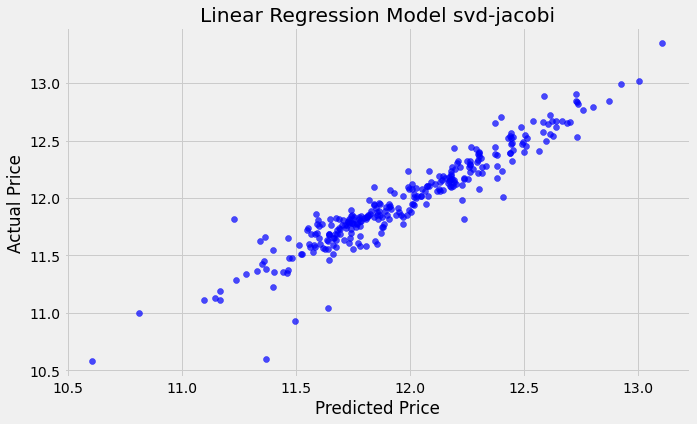

In [49]:
# alpha helps to show overlapping data
plt.scatter(preds, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model svd-jacobi')

In [50]:
df = pd.DataFrame()
df['key'] = ['eig','svd','qr','svd-qr','svd-jacobi']
df['mse'] = [mse_e,mse_s,mse_q,mse_sq,mse_sj]
df['r2s'] = [rs_e,rs_s,rs_q,rs_sq,rs_sj]
df['mae'] = [mae_e,mae_s,mae_q,mae_sq,mae_sj]

In [51]:
df

,key,mse,r2s,mae
0,eig,0.016822,0.901953,0.087097
1,svd,0.016822,0.901953,0.087097
2,qr,0.016822,0.901953,0.087097
3,svd-qr,0.016822,0.901953,0.087097
4,svd-jacobi,0.016822,0.901953,0.087097


**Submission**

In [52]:
submission = pd.DataFrame()
submission['Id'] = test['Id'].astype(int)

In [53]:
temp = test.drop(['Id'], axis = 1).interpolate()

In [54]:
predictions = reg.predict(temp)

In [55]:
predictions = np.exp(np.asarray(predictions))
submission['SalePrice'] = predictions

In [56]:
submission.to_csv('submission.csv', index = False)